# Foundations Of AIML
## Session 11
### Experiment 2.1: Extracting features using pre-trained CNN

Deep neural networks are super hungry for training data. Training data is expensive. Labelling or annotating data is a painful task. Fortunately, *for most tasks* we don't have to label/buy/crawl millions of data points to train the model. It is common to use public data from the similar domain (image, audio, text). There are thousands of researchers/students who use this data in their works. We could make use of their effort and resources spent on training the model on gigantic datasets for our task of interest. 

In this experiment we want to perform face recognition of 16 Indian celebrities from IMFDB dataset.
We simply pick the model (lightCNN) trained for face recognition on million of images and thousands of individuals. We use the feature coming out of this model to train a new classifier to identify 16 Indian celebrities.

In [19]:
%ls

config.py                      Lab11-Experiment2_2.ipynb
config.pyc                     Lab11-Experiment2_3_cpu.ipynb
contrastive.py                 Lab11-Experiment2_3.ipynb
contrastive.pyc                Lab11-Experiment3_cpu (1).ipynb
data/                          Lab11-Experiment3_cpu.ipynb
data_loader.py                 Lab11-Experiment3.ipynb
data_loader.pyc                light_cnn.py
Lab11-Experiment1_1.ipynb      light_cnn.pyc
Lab11-Experiment1_2.ipynb      __pycache__/
Lab11-Experiment1_3.ipynb      siamese_data_loader.py
Lab11-Experiment1_4.ipynb      siamese_data_loader.pyc
Lab11-Experiment2_1_cpu.ipynb  utils.py
Lab11-Experiment2_1.ipynb      utils.pyc
Lab11-Experiment2_2_cpu.ipynb


In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
from data_loader import *
## Importing python packages
import cv2
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

We will use a custom data loader to feed the images to the network (see data_loader.py). Light CNN expects grayscale 128x128 image. We do this processing in the data loader. Notice below that shuffle is True for training and False for validation. What could be the reason???

In [20]:
img_root = cf.data_dir+'IMFDB_final/'

train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print(len(train_image_list), len(val_image_list))

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128]), 
                                           batch_size=32, num_workers=16, shuffle = True, pin_memory=False)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                           batch_size=10, num_workers=5, shuffle = False, pin_memory=False)


classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']

(5000, 1095)


#### example images of 16 celebrities selected from IMFDB.

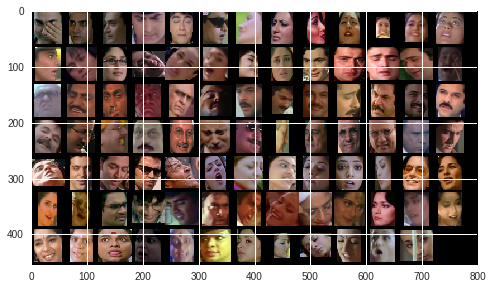

In [21]:
plt.imshow(cv2.imread(cf.data_dir+'IMFDB-16.png')[:,:,::-1])
plt.show()

In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
num_classes = 16  ### 16 celebrities

In [23]:
feature_net = network_9layers()   ### creates an object of this network architecture
feature_net = torch.load(cf.data_dir+'light_cnn/light_cnn_ckpt.t7')['net']



### Light CNN architecture is defined in light_cnn.py. We intend to use the output of FC1 layer as 256-dimensional features to train the classifier.
### we will use a 3 layers MLP as classifier. Notice the first layer has input channel equals to output feature dimension of Light CNN.
classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

if use_cuda:
    feature_net.cuda()
    classifier.cuda()

feature_net.eval()  ### since we only use the pre-trained model for feature extraction, we set it to eval mode i.e., we don't intend to update its weights.

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d (1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d (48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d (48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d (96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d (192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d (192, 256, kern

In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    classifier.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        features = feature_net.get_features(inputs).detach()         #### get_features() returns the 256-dimensional feature
        
        outputs = classifier(features)                             ### use 256-dim feature as input to the classifier.
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    classifier.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        features = feature_net.get_features(inputs).detach()
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [0]:
experiment = 'lightnet_features_IMFDB'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [0]:
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 1):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/ShirinFarhadKiTohNikalPadi/images/BomanIrani_21.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/ShirinFarhadKiTohNikalPadi/images/BomanIrani_21.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_84.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_172.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_84.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_172.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_194.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kar

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_65.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_65.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_38.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_38.jpg
creating a default image
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/3Idiots/images/Madhavan_49.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_5.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_57.jpg
ERROR: couldn't find

ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_35.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_35.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_122.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_122.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_132.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_132.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
i

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ekThaTiger/images/KatrinaKaif_12.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ekThaTiger/images/KatrinaKaif_12.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Andarivadu/images/Rimisen_2.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Andarivadu/images/Rimisen_2.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_161.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_161.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_42.jpg
ERROR: couldn't find image -> image_is_non

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_88.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_88.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_74.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_74.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Laila/images/AnilKapoor_4.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Laila/images/AnilKapoor_4.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_278.jpg
creating a default image
ERROR: couldn't 

ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/Cheli/images/Madhavan_69.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/Cheli/images/Madhavan_69.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_28.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_28.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_14.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_14.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_189.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_189

creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/Cheli/images/Madhavan_7.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/Cheli/images/Madhavan_7.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/Chameli/images/Kareena_45.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/Chameli/images/Kareena_45.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_102.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_102.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_322.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_322.jpg
creating a default i

image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Tiger1/images/Umashri_7.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_42.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_42.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_64.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_64.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_13.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_13.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/

creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_51.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_51.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_228.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_228.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Barood_1/images/AmreshPuri_2.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Barood_1/images/AmreshPuri_2.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKa

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_202.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_202.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_88.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_88.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Barood_1/images/AmreshPuri_3.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_44.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Barood_1/images/AmreshPuri_3.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Devd

ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Bobby/images/RishiKapoor_32.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Bobby/images/RishiKapoor_32.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_24.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_24.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_40.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_40.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ekThaTiger/images/KatrinaKai

image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/3Idiots/images/Madhavan_121.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/3Idiots/images/Madhavan_121.jpg
creating a default image
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Tiger2/images/Umashri_11.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/Cheli/images/Madhavan_65.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_20.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_251.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_251.jp

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_32.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_16.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_16.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_26.jpg
ERROR: couldn't find image -> 

ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_185.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_185.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_164.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_164.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_45.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_45.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_180.jpg
ERROR: couldn't find ima

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_91.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_91.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_156.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_156.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_11.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_11.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_30.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_30.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_195.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_195.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_109.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_109.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_40.jpg
ERR

ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/NoEntry/images/AnilKapoor_6.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/NoEntry/images/AnilKapoor_6.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_24.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_24.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
im

image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_127.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_42.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_42.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_6.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_6.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_214.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_214.jpg
creating a default image


image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_23.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_23.jpg
image not none resizing
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_153.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_153.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Nanjundi/images/Umashri_66.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Nanjundi/images/Umashri_66.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_66.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_66.jpg
creating a default image
imag

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_60.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_60.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_12.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_12.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_141.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrina

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_126.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_126.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_12.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_12.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_32.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_32.jpg
creating a default image
image not none resizing
image not n

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_22.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_22.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_69.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_69.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_247.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_247.jpg
crea

ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_11.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_132.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_132.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_32.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_32.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_25.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_25.jpg
creating a default image
i

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_11.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_11.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_42.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_42.jpg
image not none resizing
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_233.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_216.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/Zind

creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_5.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_5.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_50.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_50.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_126.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_126.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_30.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKh

ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_163.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_163.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_66.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_66.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/RHTDM/images/Madhavan_22.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/RHTDM/images/Madhavan_22.jpg
creating a

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_90.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_90.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_29.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_29.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_77.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_77.jpg
image not none resizing
cr

ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_69.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/SholaAurShabnam/images/AnupamKher_13.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/SholaAurShabnam/images/AnupamKher_13.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_133.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_133.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_35.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Hrithi

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_155.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_155.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_48.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesh

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_37.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_37.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Dhalapathi/images/AmreshPuri_11.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Dhalapathi/images/AmreshPuri_11.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Mr_India/images/AnilKapoor_26.jpg
creating a default image
ERROR: couldn't find ima

creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_126.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_126.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_94.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_94.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/Cheli/images/Madhavan_70.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/Cheli/images/Madhavan_70.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/Chameli/images/Kareena_36.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/

creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_40.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_40.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/Cheli/images/Madhavan_26.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/Cheli/images/Madhavan_26.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_187.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_187.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/3Idiots/images/Madhavan_55.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/3Idiots/images/Madhavan_55.jpg


creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_69.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_69.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_26.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_26.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_33.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_33.jpg
creating a default image


image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_10.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_10.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_37.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_37.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_138.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_138.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_137.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_137.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_191.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_191.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/H

ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_93.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_93.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_104.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_104.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Tiger2/images/Umashri_21.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Tiger2/images/Umashri_21.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_60.jpg
ERROR: couldn't find image

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_257.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Hrudayanjali/images/Umashri_10.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_257.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Hrudayanjali/images/Umashri_10.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_157.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_157.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Laila/images/AnilKapoor_3.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Laila/images/AnilKapoor_3.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_110.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_110.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_92.jpg
ERROR: couldn

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Barood/images/AmreshPuri_14.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Barood/images/AmreshPuri_14.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_66.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_161.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_161.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_66

ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_148.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_148.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_34.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_34.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_81.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_81.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_45.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_45.jpg
creating a default image
image not 

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_168.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_168.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_149.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_149.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_18.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/An

ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_65.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_65.jpg
image not none resizing
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/HumApkeHaiKoun/images/AnupamKher_1.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/HumApkeHaiKoun/images/AnupamKher_1.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_17.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_17.jpg
creating a default image
image not none resizing
i

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_37.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_37.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_8.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_8.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_190.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_261.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_190.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_261.jpg
creating a d

ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/3Idiots/images/Irani_57.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/3Idiots/images/Irani_57.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_94.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_94.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/JolyLLB/images/BomanIrani_29.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/JolyLLB/images/BomanIrani_29.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_94.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiK

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_1.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_1.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Mr_India/images/AnilKapoor_25.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_231.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_231.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_97.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_142.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_142.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_51.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_301.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_51.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_301.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_111.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_117.jpg
creating a default image
image not none resizing
creat

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_100.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_100.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_150.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_150.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_49.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_11.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_11.jpg
ERROR: couldn't find image -

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_99.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_99.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Dhalapathi/images/AmreshPuri_6.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Dhalapathi/images/AmreshPuri_6.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
im

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_195.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_195.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_169.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_169.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_157.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_157.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
i

ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/MrPerfect/images/KajalAgarwal_5.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/MrPerfect/images/KajalAgarwal_5.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Hrudayanjali/images/Umashri_30.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Hrudayanjali/images/Umashri_30.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Bobby/images/RishiKapoor_77.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_4.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_176.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Bobby/images/RishiKapoor_77.jpg
ERROR: c

ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_87.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_57.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_57.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_296.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_296.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_21.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_21.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final

ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_178.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_178.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_1.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_136.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_136.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_84.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_84.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_10.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_10.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_52.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_52.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_192.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_192.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_87.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_87.jpg
creating a default image
image not 

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_48.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_142.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_48.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_142.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Barood/images/AmreshPuri_17.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Barood/images/AmreshPuri_17.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_fina

creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Dil/images/AnupamKher_6.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_37.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_37.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_113.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_113.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_4.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_4.jpg
ERROR: couldn't find image ->  isfil

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_191.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_191.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_153.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_153.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_81.jpg
image not none res

ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_169.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_259.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/3Idiots/images/Irani_29.jpg
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/3Idiots/images/Irani_29.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_26.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_211.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_26.jpg
ERROR: couldn't find imag

ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_105.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_55.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_102.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_1.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_55.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_102.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_1.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->

creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/Chameli/images/Kareena_59.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/Chameli/images/Kareena_59.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_150.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_150.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_43.jpg
ERROR: couldn't find image -> image_is_none data/

ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_76.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_113.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_113.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Mr_India/images/AnilKapoor_8.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Mr_India/images/AnilKapoor_8.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_4.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_4.jpg
creating a default image
image not none resizing
image not none resizing
image not none re

ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_135.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_135.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_44.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_238.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_44.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_104.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_238.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDi

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/3Idiots/images/Irani_95.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_129.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/3Idiots/images/Irani_95.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_129.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_155.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_155.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_54.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKh

ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_189.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_188.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_188.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_30.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_30.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizin

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_103.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_103.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_92.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_92.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_70.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images

ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Lalihadu/images/Umashri_43.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_25.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_58.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_25.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_58.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_57.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_57.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none

ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Barood_1/images/AmreshPuri_6.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Barood_1/images/AmreshPuri_6.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_187.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_187.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_161.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_161.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image 

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_155.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_155.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_8.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_8.jpg
image not none resizing
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_117.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_117.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_54.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/RHTDM/images/Madhavan_13.jpg
ERROR: couldn't find image ->  isfile data/

ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/odahuttidavaru/images/Umashri_11.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/odahuttidavaru/images/Umashri_11.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Tiger1/images/Umashri_5.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Tiger1/images/Umashri_5.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_58.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_58.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_118.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/ima

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_4.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/HumHaiKamalKe/images/AnupamKher_4.jpg
image not none resizing
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_82.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/MrPerfect/images/KajalAgarwal_8.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/Chameli/images/Kareena_10.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_82.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Mr

ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_154.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_18.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_18.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_67.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_67.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_76.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Ris

creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_11.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_109.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_11.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_47.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_109.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_47.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_12.jpg
creating a default image
creating a default image
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_1

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_169.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_169.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_100.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_100.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_23.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_23.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Hr

ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_95.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_95.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_44.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_44.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ekThaTiger/images/KatrinaKaif_56.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ekThaTiger/images/KatrinaKaif_56.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_262.jpg
ERROR: 

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_192.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_192.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_132.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_132.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_133.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_133.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_5.jpg
ERROR: coul

ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_126.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_126.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_37.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_37.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_28.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_28.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_8.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_26.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_26.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_55.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_55.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_99.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_99.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find ima

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/3Idiots/images/Irani_48.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_112.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Lalihadu/images/Umashri_8.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_112.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/3Idiots/images/Irani_48.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Lalihadu/images/Umashri_8.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_65.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_65.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none res

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_21.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/Hrudayanjali/images/Umashri_18.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Hrudayanjali/images/Umashri_18.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_21.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_81.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_81.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_237.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_237.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_201.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_201.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_231.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_231.jpg
creating a def

ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_182.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_182.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_1.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/KothigaluSirKothigalu/images/Umashri_1.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_19.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_19.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVen

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_50.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_50.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_127.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_127.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/Cheli/images/Madhavan_19.jpg
ERROR: couldn't find 

creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_8.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_8.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_114.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_114.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_115.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_115.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_190.jpg
ERROR: couldn't fin

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_25.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_25.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_186.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_186.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_249.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_249.jpg
image not none resizing
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_289.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_f

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_155.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_155.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_107.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_107.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IM

creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_26.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_4.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Nayak/images/AnilKapoor_26.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_4.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_100.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_100.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resiz

ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_202.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_202.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_244.jpg
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_244.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_17.jpg
ERROR: cou

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_45.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_45.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_55.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_55.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_147.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_147.jpg
creating a default image
E

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_257.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_257.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_131.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_131.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_110.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nam

ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_10.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_187.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_187.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_159.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_159.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_67.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_67.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/Rimi

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_195.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_195.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_37.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_37.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_98.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrinakaif_98.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_

ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_6.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Brindavanam/images/KajalAgarwal_33.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Brindavanam/images/KajalAgarwal_33.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_2.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_2.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Hu

ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_196.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_39.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_39.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_196.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_177.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_6.jpg
ERROR: couldn't find image -> image_is_none dat

image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_12.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_12.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_129.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_129.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_146.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_146.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none 

creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_17.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_17.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_370.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_370.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_3.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_3.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_206.jpg
ERRO

ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Darling/images/KajalAgarwal_59.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_285.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_285.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_68.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_68.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image 

creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_113.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_41.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_41.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_113.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_128.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_128.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_181.jpg
ERROR: cou

ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_25.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_25.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Umashri/Nanjundi/images/Umashri_53.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_92.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_92.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_40.jpg
ERROR: couldn't find image -> ima

ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_195.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_207.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_207.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_38.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_38.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_135.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_135.jpg
creating a default image
creating a default

creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_40.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_40.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_73.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_73.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_119.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_119.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfil

ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_12.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_12.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_88.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/MunnabhaiMBBS/images/BomanIrani_88.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_19.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_19.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/JolyLLB/images/BomanIrani_24.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_96.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_96.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_91.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_91.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_141.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_141.jpg
creating a default image
image not none 

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_14.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_14.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Brindavanam/images/KajalAgarwal_31.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Brindavanam/images/KajalAgarwal_31.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/K

ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_84.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_73.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Madhavan/MydearMunnabhai/images/Madhavan_73.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_1.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_1.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_45.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/3Idiots/images/Kareena_45.jpg
creating a default image
image no

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_109.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/HumApkeHaiKoun/images/MadhuriDixit_109.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_33.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_33.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_12.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_12.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_109.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapo

ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Mr_India/images/AnilKapoor_29.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_16.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Mr_India/images/AnilKapoor_29.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_22.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_22.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_33.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_33.jpg
creating a default image
image not none resiz

ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_41.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/meraBrotherKiDhulan/images/KatrinaKaif_41.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_112.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_112.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_19.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/KabhiKhushiKabhiGham/images/HrithikRoshan_19.jpg
creating a default image
ima

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_98.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_22.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_98.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_22.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Bobby/images/RishiKapoor_30.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Bobby/images/RishiKapoor_30.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_231.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_231.jpg

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_134.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/AndazApnaApna/images/AamirKhan_134.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_132.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_132.jpg
creating a default image
image not none resizing
image not none resizing
image 

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_134.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_134.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_58.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/TeesMaarKhan/images/KatrinaKaif_58.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_67.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_67.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ima

creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_159.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_159.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_83.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_83.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_78.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_78.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_94.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishP

image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_86.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Misc/images/MadhuriDixit_86.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KatrinaKaif/ekThaTiger/images/KatrinaKaif_52.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_178.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_fin

ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_80.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_34.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_34.jpg
creating a default image
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_89.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KuchKuchhotahai/images/Kajol_89.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: co

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_120.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_92.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_120.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_92.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_141.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Misc/images/AmrishPuri_141.jpg
creating a default image
creating a default image
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing

image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_137.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/JamaiRaja/images/MadhuriDixit_137.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_179.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_179.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/BomanIrani/3Idiots/images/Irani_85.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/BomanIrani/3Idiots/images/Irani_85.jpg
creating a default image
ERROR: couldn't find image ->  

ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_55.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_55.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_55.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_123.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/MadhuriDixit/Devdas/images/MadhuriDixit_55.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_123.jpg
creating a default image
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_57.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/An

ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_59.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/YehVadhaRaha/images/RishiKapoor_59.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_184.jpg
image not none resizing
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_184.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Rimisen/Misc/images/RimiSen_95.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Rimisen/Misc/images/RimiSen_95.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/SholaAurShabnam/images/AnupamKher_12.jpg
ERROR: couldn't fi

ERROR: couldn't find image -> image_is_none data/IMFDB_final/Kajol/KabhiKhushiKabhiGham/images/Kajol_189.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_52.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_52.jpg
image not none resizing
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_7.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnupamKher/Misc/images/AnupamKher_7.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/AnilKapoor_16.jpg
ERROR: co

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_56.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_56.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_332.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_332.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none res

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_42.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_42.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_120.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/HrithikRoshan/ZindagiNaMilegiDobara/images/HirtikRoshan_120.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_f

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/3Idiots/images/Amir_97.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_69.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/3Idiots/images/Amir_97.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/KabhiKhushiKabhiGham/images/Kareenakapoor_69.jpg
creating a default image
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_229.j

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_157.jpg
ERROR: couldn't find image ->  isfile data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_6.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KareenaKapoor/MaiAurMsKhanna/images/Kareena_6.jpg
creating a default image
ERROR: couldn't find image -> image_is_none data/IMFDB_final/KajalAgarwal/Misc/images/KajolAggarwal_157.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_116.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/RishiKapoor/Misc/images/RishiKapoor_116.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/KatrinaKaif/ZindagiNaMilegiDobara/images/Katrina

image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_10.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AmrishPuri/Nayak/images/AmreshPuri_10.jpg
creating a default image
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_22.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/NamoVenkatesha/images/Trisha_22.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_41.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AnilKapoor/Misc/images/AnilKapoor_41.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AnilKapoor/JamaiRaja/images/An

image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
ERROR: couldn't find image ->  isfile data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_81.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/Trisha/Nuvvostanante_Nenoddantana/images/Trisha_81.jpg
creating a default image
ERROR: couldn't find image ->  isfile data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_64.jpg
ERROR: couldn't find image -> image_is_none data/IMFDB_final/AamairKhan/Dil/images/AmirKhan_64.jpg
creating a default image
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
image not none resizing
imag

In [1]:
training_curves(cf.data_dir+experiment)

NameError: ignored

Lets evaluate the classifier and see the mistakes it made. Confusion matrix gives the quantitative measure of the mistakes. The diagonal elements shows the correct classification and others shows the mistake. We want the diagonal elements of this matrix to be close to 1.

In [0]:
### After training we load the model that performed the best on validation data (avoid picking overfitted model)
classifier = torch.load(cf.data_dir+'/checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [0]:
def eval():
    
    classifier.eval()
    testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                           batch_size=1, num_workers=1, shuffle = False, pin_memory=False)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if batch_idx%100 == 0:
            print(batch_idx)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        features = feature_net.get_features(inputs).detach()
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [17]:
conf, acc, wrong_predictions = eval()
print('Accuracy:', acc, '%')

image not none resizing
0


RuntimeError: ignored

This means the feature are indeed useful. 60% classification accuracy for 16 classes. Lets see the confusion matrix. Notice 'jet' colormap is used to enhance contrast. dark blue is 0, green/yellow is somewhere in between, and dark red is 1 (Blue-Green-Yellow-Orange-Red order).

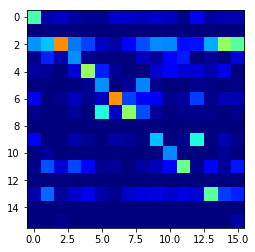

In [0]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

Trisha confused with Kajol


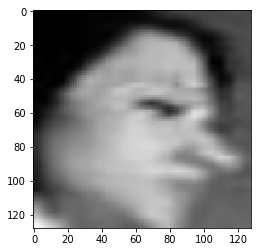

Madhavan confused with Kajol


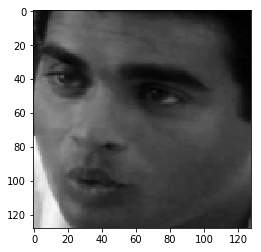

Madhavan confused with AnilKapoor


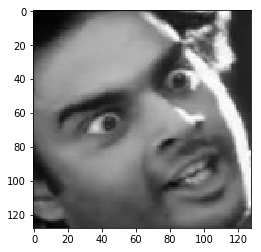

AnupamKher confused with Kajol


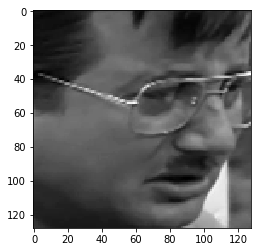

RishiKapoor confused with Kajol


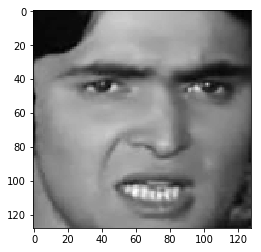

Trisha confused with AnilKapoor


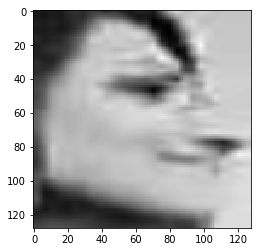

Umashri confused with Kajol


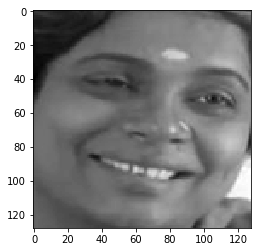

BomanIrani confused with AnupamKher


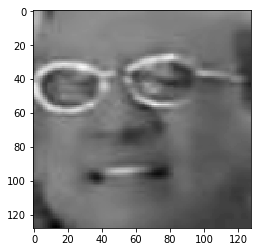

MadhuriDixit confused with RishiKapoor


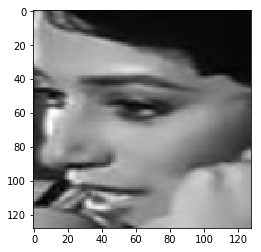

Madhavan confused with HrithikRoshan


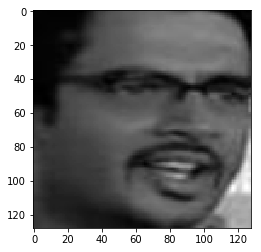

KareenaKapoor confused with Kajol


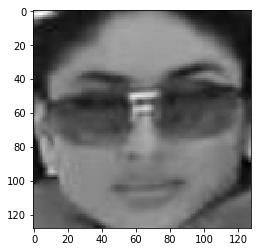

AnupamKher confused with HrithikRoshan


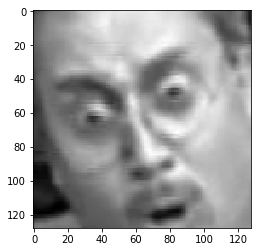

AnilKapoor confused with AnupamKher


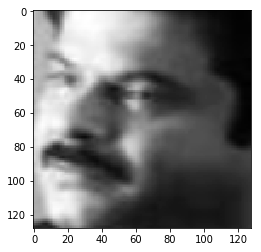

Madhavan confused with AamairKhan


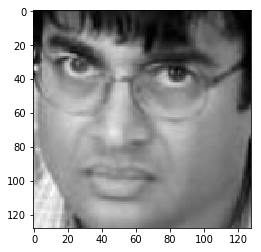

Umashri confused with Kajol


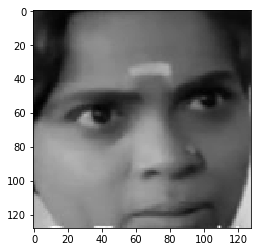

Trisha confused with KareenaKapoor


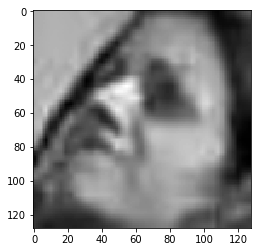

AamairKhan confused with AnilKapoor


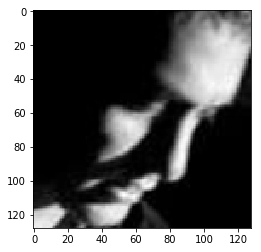

Rimisen confused with Kajol


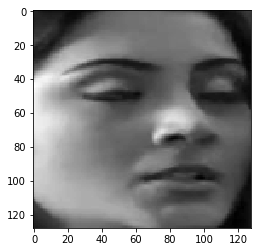

Umashri confused with Kajol


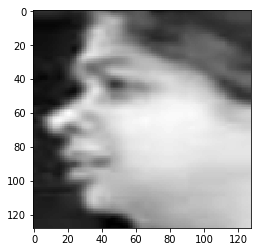

RishiKapoor confused with Kajol


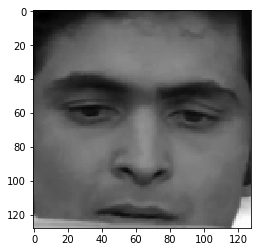

AamairKhan confused with Kajol


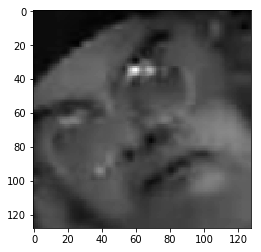

KajalAgarwal confused with Kajol


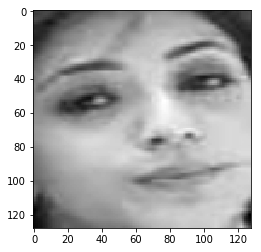

Madhavan confused with HrithikRoshan


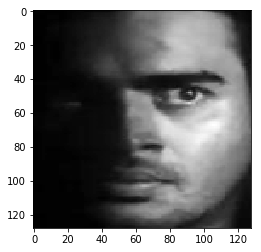

MadhuriDixit confused with Kajol


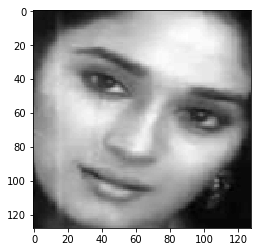

Trisha confused with HrithikRoshan


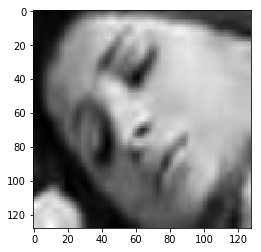

KatrinaKaif confused with RishiKapoor


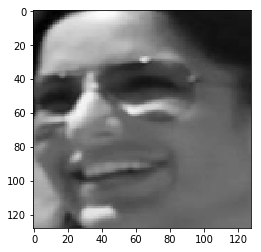

Trisha confused with KareenaKapoor


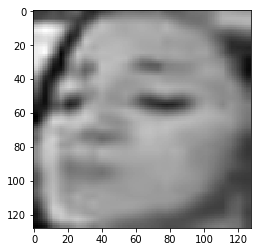

AamairKhan confused with AnilKapoor


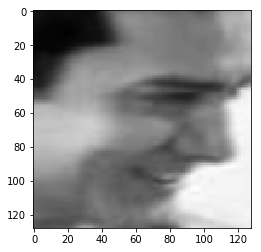

Trisha confused with Kajol


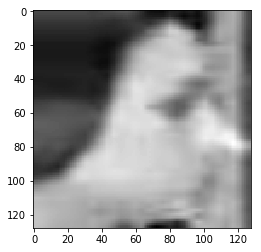

KajalAgarwal confused with Kajol


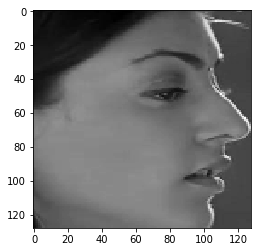

Rimisen confused with MadhuriDixit


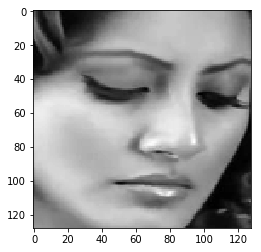

KatrinaKaif confused with HrithikRoshan


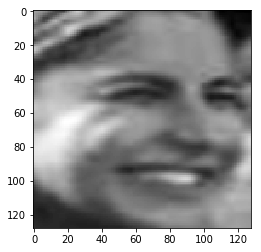

Madhavan confused with AnilKapoor


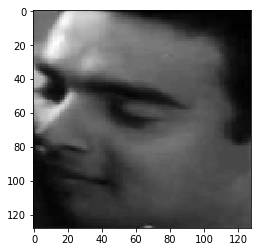

KareenaKapoor confused with MadhuriDixit


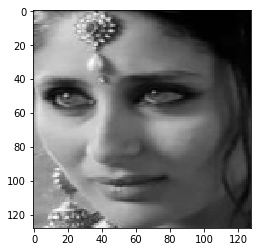

Rimisen confused with KareenaKapoor


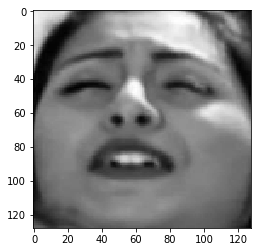

Rimisen confused with KatrinaKaif


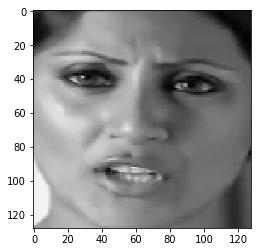

AamairKhan confused with AnilKapoor


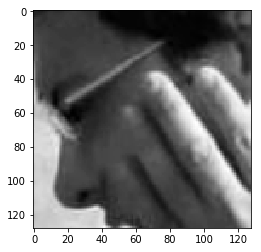

Rimisen confused with KareenaKapoor


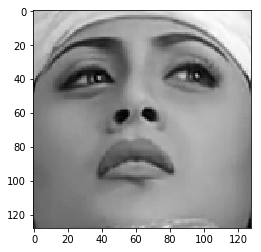

Trisha confused with Kajol


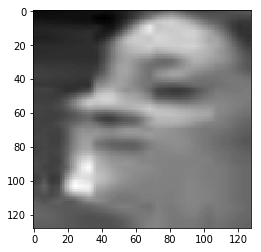

AamairKhan confused with Kajol


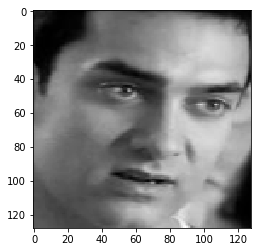

Madhavan confused with HrithikRoshan


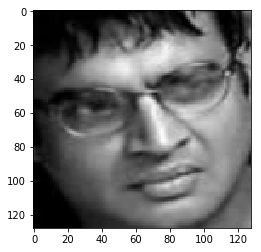

Trisha confused with Kajol


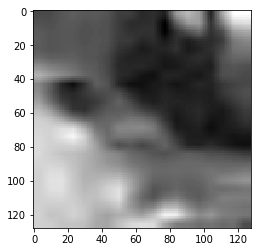

Kajol confused with MadhuriDixit


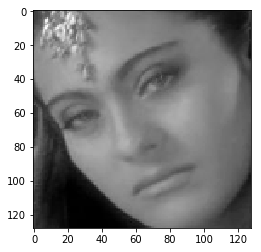

Trisha confused with Kajol


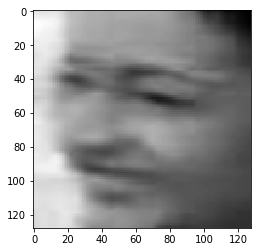

KajalAgarwal confused with Kajol


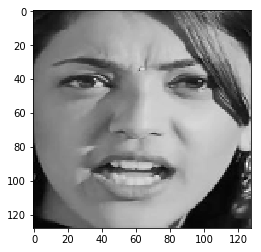

Umashri confused with Kajol


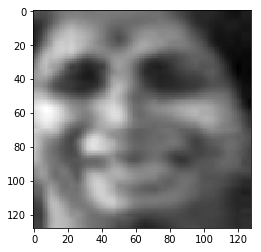

BomanIrani confused with AmrishPuri


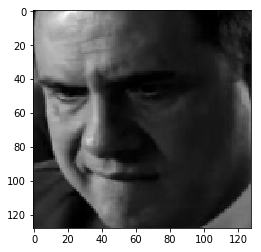

AmrishPuri confused with RishiKapoor


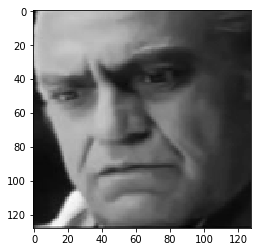

AnilKapoor confused with KatrinaKaif


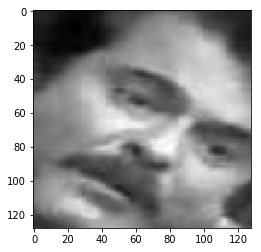

KareenaKapoor confused with Kajol


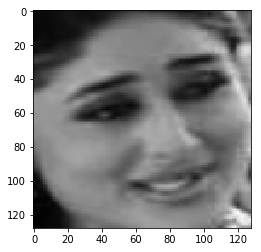

BomanIrani confused with AamairKhan


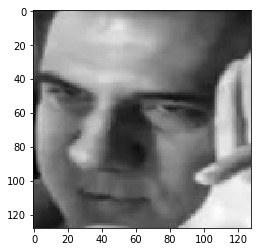

Rimisen confused with MadhuriDixit


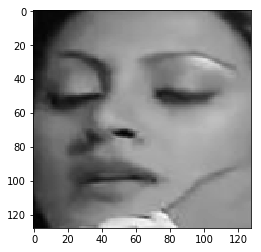

Trisha confused with Kajol


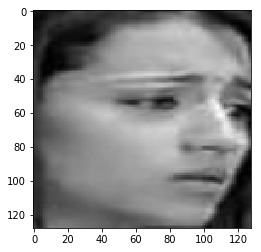

AnilKapoor confused with KatrinaKaif


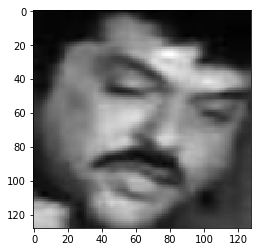

BomanIrani confused with AnupamKher


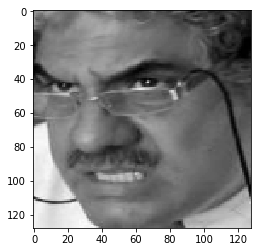

AamairKhan confused with Kajol


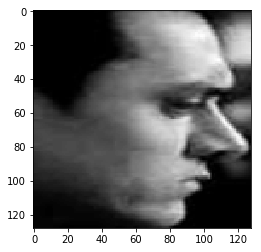

Trisha confused with MadhuriDixit


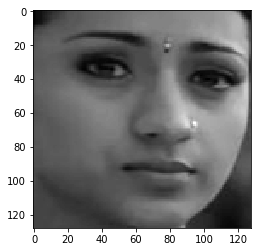

AnilKapoor confused with Kajol


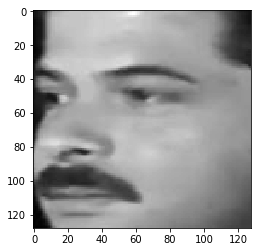

MadhuriDixit confused with KatrinaKaif


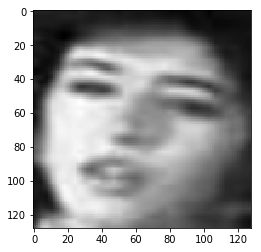

MadhuriDixit confused with AnilKapoor


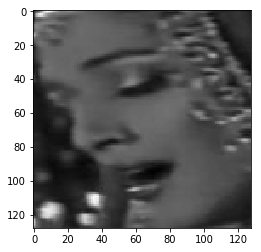

Kajol confused with KatrinaKaif


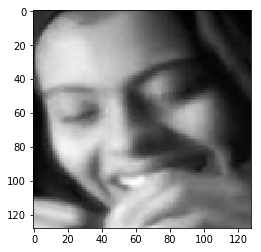

KajalAgarwal confused with KareenaKapoor


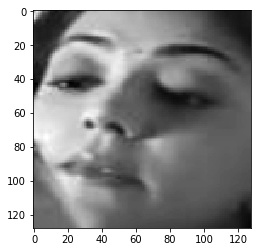

Madhavan confused with Kajol


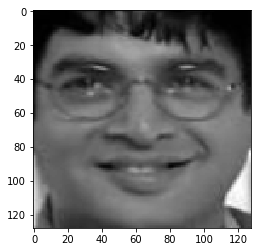

Umashri confused with Kajol


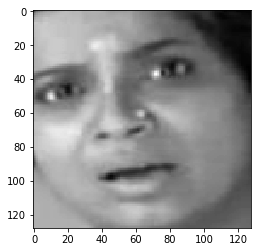

Madhavan confused with MadhuriDixit


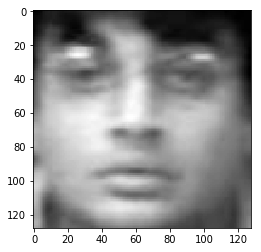

MadhuriDixit confused with Kajol


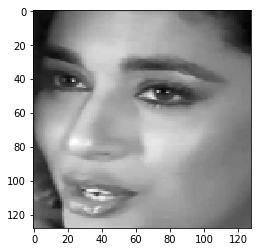

Umashri confused with MadhuriDixit


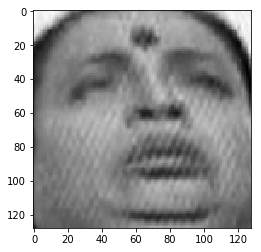

AmrishPuri confused with Kajol


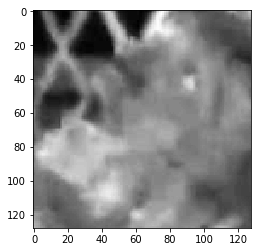

Trisha confused with Kajol


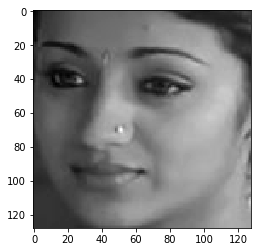

AmrishPuri confused with RishiKapoor


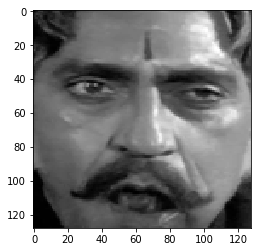

KareenaKapoor confused with RishiKapoor


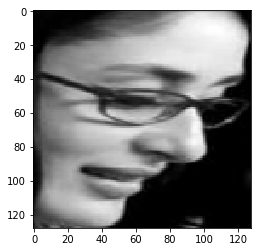

MadhuriDixit confused with KatrinaKaif


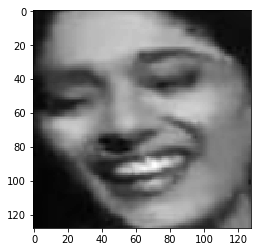

In [0]:
for w in wrong_predictions[::10]:
    print(classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()